In [294]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import mesh
import geometry
import material
from stress_strain_analysis import stress_strain_analysis

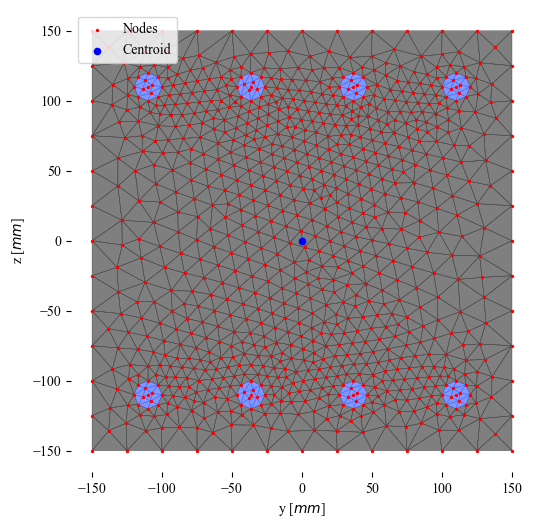

╒════════════════════╤══════════╕
│ Mesh Type          │ triangle │
├────────────────────┼──────────┤
│ Number of elements │ 1694     │
├────────────────────┼──────────┤
│ Number of nodes    │ 880      │
├────────────────────┼──────────┤
│ Cross Section Area │ 90000.00 │
╘════════════════════╧══════════╛
╒═══════════════════╤══════════════╤══════════════╕
│                   │            y │            z │
╞═══════════════════╪══════════════╪══════════════╡
│ Centroid          │         0.00 │         0.00 │
├───────────────────┼──────────────┼──────────────┤
│ Moment of inertia │ 675000000.00 │ 675000000.00 │
╘═══════════════════╧══════════════╧══════════════╛


In [295]:
ReinforcedConcrete = geometry.ReinforcedConcreteColumn(width  = 300, 
                                                       height = 300, 
                                                       concrete_cover = 30,
                                                       rebar_diameter = 20,
                                                       rebar_spacing  = 50)
Mesh = mesh.Mesh(ReinforcedConcrete, "triangle", 25)

Mesh.plot()
Mesh.print()

In [307]:
Analysis = stress_strain_analysis(Mesh)

Analysis.set_strain_and_curvature(0, 0.0000004, 0.0000002)

Analysis.calculate_strains()
Analysis.calculate_stresses()

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.tri as tri
from matplotlib import cm, colors

def plot_stress_strain(self):

	# Normalize strains for color mapping
	max_strain = max(abs(min(self.strains*100)), abs(max(self.strains*100)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (strains, stresses) = plt.subplots(1,2, figsize=(8, 4), dpi=300)
	
	for i, elem in enumerate(self.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(self.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(self.mesh.node_coords[:, 0],
			self.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(self.mesh.node_coords[:, 0].min(), self.mesh.node_coords[:, 0].max())
	strains.set_ylim(self.mesh.node_coords[:, 1].min(), self.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_strain = max(abs(min(self.stresses)), abs(max(self.stresses)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	for i, elem in enumerate(self.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(self.stresses[i])),
								lw=0.3)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(self.mesh.node_coords[:, 0],
			self.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=stresses, label=r"stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(self.mesh.node_coords[:, 0].min(), self.mesh.node_coords[:, 0].max())
	stresses.set_ylim(self.mesh.node_coords[:, 1].min(), self.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')
	plt.tight_layout()
	plt.suptitle(f"$\\epsilon$ = {(self.eps_x * 100):.3f} [%], $\\chi_y$ = {(self.xsi_y *1000):.4f} [mrad], $\\chi_z$ = {(self.xsi_z*1000):.4f} [mrad]")
	plt.show()

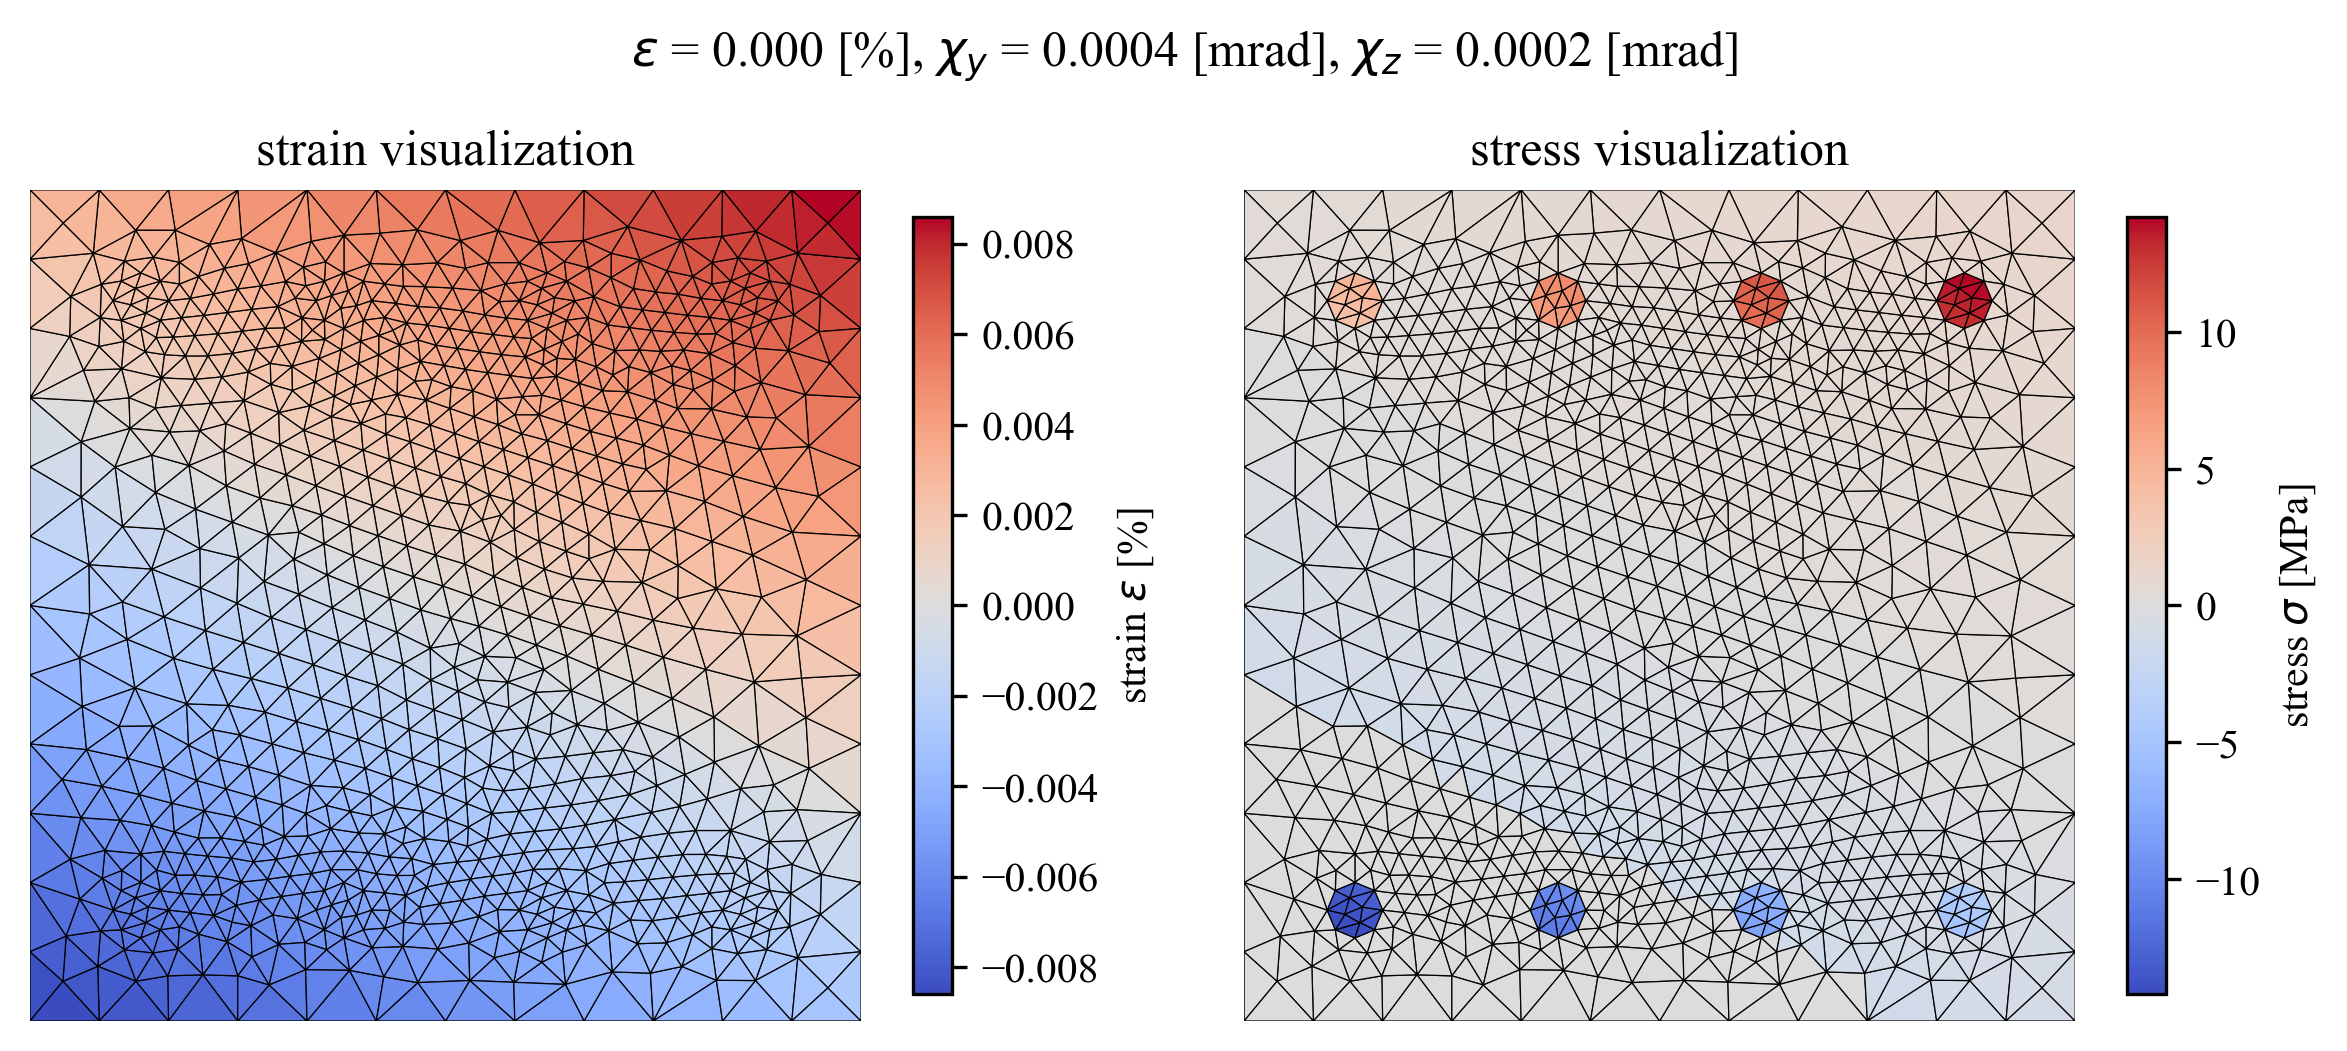

In [308]:
plot_stress_strain(Analysis)

In [309]:
Analysis.get_section_forces()

(6.721998950121661, 5.612248265412263, 1.8542232508940546)

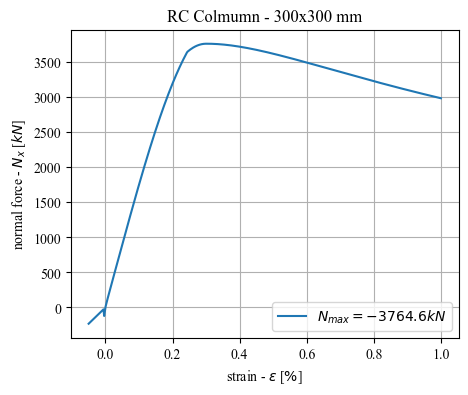

In [27]:
strains = np.linspace(-0.0005, 0.01, 500)

Nx = []

for strain in strains:
    Analysis.set_strain_and_curvature(strain, 0, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx.append(Analysis.get_section_forces()[0])


plt.figure(figsize=(5, 4))
plt.plot(strains * 100, Nx, label=r"$N_{{max}} = {:.1f} kN$".format(-max(Nx)))
plt.xlabel(r'strain - $\varepsilon$ [$\%$]')
plt.ylabel(r'normal force - $N_x$ [$kN$]')
plt.title("RC Colmumn - 300x300 mm")
plt.grid()
plt.legend()
plt.savefig('images/concrete/300x300_N.png', dpi=300, bbox_inches='tight')
plt.show()

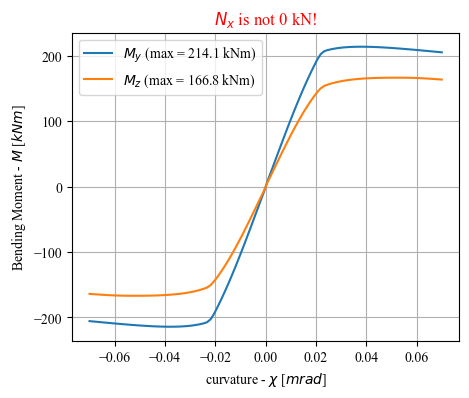

In [34]:
curvs = np.linspace(-0.00007, 0.00007, 100)

My = []
Mz = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])
    Analysis.set_strain_and_curvature(0, 0, curv)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Mz.append(Analysis.get_section_forces()[2])


plt.figure(figsize=(5, 4))
plt.plot(curvs * 1000, My, label=f'$M_y$ (max = {max(My):.1f} kNm)')
plt.plot(curvs * 1000, Mz, label=f'$M_z$ (max = {max(Mz):.1f} kNm)')
plt.xlabel(r'curvature - $\chi$ [$mrad$]')
plt.ylabel(r'Bending Moment - $M$ [$kNm$]')
plt.title("$N_x$ is not 0 kN!", color='red')
plt.grid()
plt.legend()
plt.savefig('images/concrete/300x300_M.png', dpi=300, bbox_inches='tight')
plt.show()

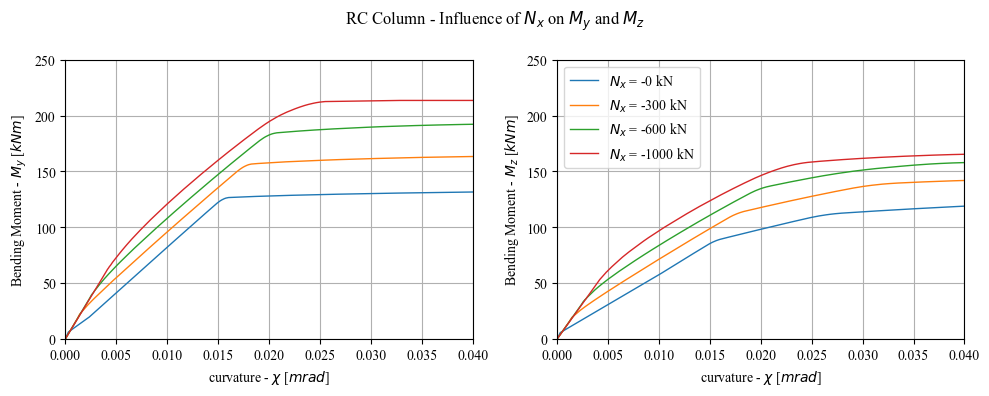

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(0, 250, 501)
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
fig, (my, mz) = plt.subplots(1,2, figsize=(10, 4))
for j, target_N in enumerate([0, 300, 600, 1000]):
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(system_of_equations, initial_guess, args=(target_N, M, 0), full_output=1)
		if result[2] == 1:
			xsi.append(result[0][1])
			M_res.append(M)
	xsi.append(0.00005)
	M_res.append(M_res[-1])
	my.plot([x * 1000 for x in xsi], M_res,linestyle='-',  color=colors[j], lw=1)

Mz = np.linspace(0, 250, 501)

for j, target_N in enumerate([0, 300, 600, 1000]):
	xsi = []
	M_res = []
	for i, M in enumerate(Mz):
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(system_of_equations, initial_guess, args=(target_N, 0, M), full_output=1)
		if result[2] == 1:
			xsi.append(result[0][2])
			M_res.append(M)
	mz.plot([x * 1000 for x in xsi], M_res,linestyle='-', label=f'$N_x$ = -{target_N} kN', color=colors[j], lw=1)

# Plotting the results
plt.suptitle('RC Column - Influence of $N_x$ on $M_y$ and $M_z$')
mz.legend()
my.grid()
mz.grid()
my.set_xlim(0, 0.04)
mz.set_xlim(0, 0.04)
my.set_ylim(0, 250)
mz.set_ylim(0, 250)
my.set_xlabel(r'curvature - $\chi$ [$mrad$]')
mz.set_xlabel(r'curvature - $\chi$ [$mrad$]')
my.set_ylabel(r'Bending Moment - $M_y$ [$kNm$]')
mz.set_ylabel(r'Bending Moment - $M_z$ [$kNm$]')
plt.tight_layout()
plt.savefig('images/concrete/300x300_N_on_My_Mz.png', dpi=300, bbox_inches='tight')
plt.show()

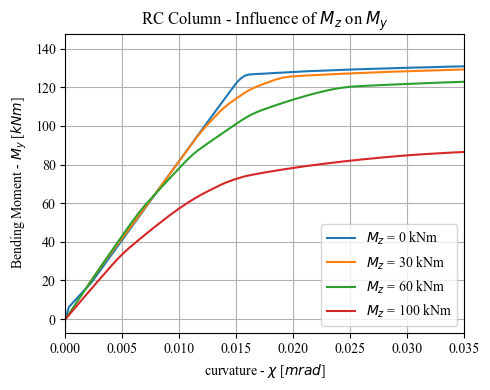

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(0, 250, 1001)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
plt.figure(figsize=(5, 4))
for target_Mz in [0, 30, 60, 100]:
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		target_My = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(0, target_My, target_Mz), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	plt.plot([x * 1000 for x in xsi], M_res,linestyle='-', label=f'$M_z$ = {target_Mz} kNm')

# Plotting the results
plt.title('RC Column - Influence of $M_z$ on $M_y$')
plt.legend()
plt.grid()
plt.xlim(0, 0.035)
plt.xlabel(r'curvature - $\chi$ [$mrad$]')
plt.ylabel(r'Bending Moment - $M_y$ [$kNm$]')
plt.tight_layout()
plt.savefig('images/concrete/300x300_Mz_on_My.png', dpi=300, bbox_inches='tight')
plt.show()

In [104]:
N = np.linspace(-1150, 1150, 47)
My = np.linspace(-250, 250, 201)
M_min = [0]
M_max = [0]
Mz = 0

# Find N_min and N_max
N_large = np.linspace(0, 4000, 1001)
N_small = np.linspace(0,-1500, 1001)
N_min = 0
N_max = 0


for i, N_target in enumerate(N_small):
	initial_guess = [-0.00001, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		print(N_target)
		N_min = N_target

N_solutions = [N_min]
print(N_min, N_max)

-1.5
-3.0
-4.5
-6.0
-7.5
-9.0
-10.5
-12.0
-13.5
-15.0
-16.5
-18.0
-19.5
-21.0
-22.5
-24.0
-25.5
-27.0
-28.5
-30.0
-31.5
-33.0
-34.5
-36.0
-37.5
-39.0
-40.5
-42.0
-43.5
-45.0
-46.5
-48.0
-49.5
-51.0
-52.5
-54.0
-55.5
-57.0
-58.5
-60.0
-61.5
-63.0
-64.5
-66.0
-67.5
-69.0
-70.5
-72.0
-73.5
-75.0
-76.5
-78.0
-79.5
-81.0
-82.5
-84.0
-85.5
-87.0
-88.5
-90.0
-91.5
-93.0
-94.5
-96.0
-97.5
-99.0
-100.5
-102.0
-103.5
-105.0
-106.5
-108.0
-109.5
-111.0
-112.5
-114.0
-115.5
-117.0
-118.5
-120.0
-121.5
-123.0
-124.5
-126.0
-127.5
-129.0
-130.5
-231.0
-232.5
-234.0
-235.5
-237.0
-238.5
-240.0
-241.5
-243.0
-244.5
-246.0
-247.5
-249.0
-250.5
-252.0
-253.5
-255.0
-256.5
-258.0
-259.5
-261.0
-262.5
-264.0
-265.5
-267.0
-268.5
-270.0
-271.5
-273.0
-274.5
-276.0
-277.5
-279.0
-280.5
-282.0
-283.5
-285.0
-286.5
-288.0
-289.5
-291.0
-292.5
-294.0
-295.5
-297.0
-298.5
-300.0
-301.5
-303.0
-304.5
-306.0
-307.5
-309.0
-310.5
-312.0
-313.5
-315.0
-316.5
-318.0
-319.5
-321.0
-322.5
-324.0
-325.5
-327.0
-328.5
-

-1220.0 3764.0


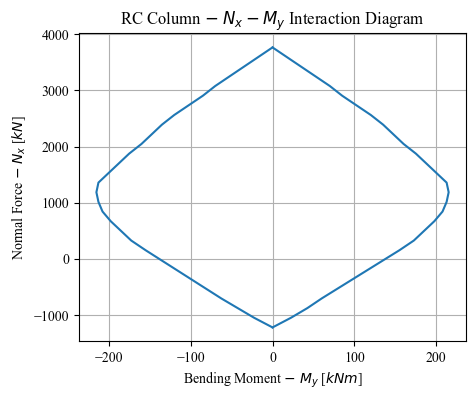

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-1150, 1150, 47)
My = np.linspace(-250, 250, 201)
M_min = [0]
M_max = [0]
Mz = 0

# Find N_min and N_max
N_large = np.linspace(0, 4000, 1001)
N_small = np.linspace(0,-1500, 376)
N_min = 0
N_max = 0

for i, N_target in enumerate(N_large):
	initial_guess = [+0.00001, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_max = N_target

for i, N_target in enumerate(N_small):
	initial_guess = [-0.00001, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_min = N_target

N_solutions = [N_min]
print(N_min, N_max)
N = np.linspace(N_min, N_max, 30)

for i, N_target in enumerate(N):
    M_res = []
    for i, M in enumerate(My):
        target_M = M
        if N_target < -600:
            initial_guess = [-0.00001, 0.0, 0.0]  # Initial guess for eps and xsi			
            result = fsolve(system_of_equations, initial_guess, args=(N_target, target_M, Mz), full_output=1)
            if result[2] == 1:
                M_res.append(M)
        elif N_target > 100:
            initial_guess = [+0.00001, 0.0, 0.0]
            result = fsolve(system_of_equations, initial_guess, args=(N_target, target_M, Mz), full_output=1)
            if result[2] == 1:
                M_res.append(M)
    if len(M_res) > 0:
        # Append the minimum and maximum M values for the current N
		# Check if M_res is not empty before appending
        M_min.append(min(M_res))
        M_max.append(max(M_res))
        N_solutions.append(N_target)

M_min.append(0)
M_max.append(0)
N_solutions.append(N_max)

# Plotting the results
plt.figure(figsize=(5, 4))
plt.plot(M_min, N_solutions,linestyle='-', color='C0')
plt.plot(M_max, N_solutions,linestyle='-', color='C0')
plt.grid()
plt.xlabel('Bending Moment $-$ $M_y$ [$kNm$]')
plt.ylabel('Normal Force $-$ $N_x$ [$kN$]')
plt.title('RC Column $-$ $N_x-M_y$ Interaction Diagram')
plt.savefig('images/concrete/300x300_N_M_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

140.5
178.5
205.5


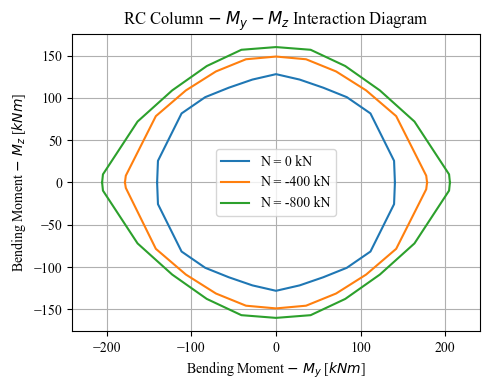

In [130]:
plt.figure(figsize=(5, 4))
c = ['C0', 'C1', 'C2']

for i, N_target in enumerate([0, 400, 800]):
	# --- Parameters ---
	Mz_range = np.linspace(-160, 160, 201)

	# --- Initialize result containers ---
	Mz_neg = [0]
	Mz_pos = [0]

	# Find My_min and My_max
	My = np.linspace(0, 250, 501)

	for My_target in My:
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			My_max = My_target

	My_sol = [-My_max]
	print(My_max)
	
	My_range = np.linspace(-My_max+1, My_max-1, 11)

	# --- Main sweep over My and Mz grid ---
	for My in My_range:
		Mz_success = []
		for Mz in Mz_range:
			initial_guess = [0.000001, 0.000001, 0.000001]
			result = fsolve(system_of_equations, initial_guess, args=(N_target, My, Mz), full_output=1)
			if result[2] == 1:
				Mz_success.append(Mz)
		if len(Mz_success) > 0:
			My_sol.append(My)
			Mz_neg.append(min(Mz_success))
			Mz_pos.append(max(Mz_success))
	
	My_sol.append(My_max)
	Mz_neg.append(0)
	Mz_pos.append(0)

	plt.plot(My_sol, Mz_neg, color=c[i])
	plt.plot(My_sol, Mz_pos, color=c[i], label=f"N = {-N_target} kN")


plt.xlabel("Bending Moment $-$ $M_y$ [$kNm$]")
plt.ylabel("Bending Moment $-$ $M_z$ [$kNm$]")
plt.title("RC Column $-$ $M_y-M_z$ Interaction Diagram")
plt.grid()
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig('images/concrete/300x300_My_Mz_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

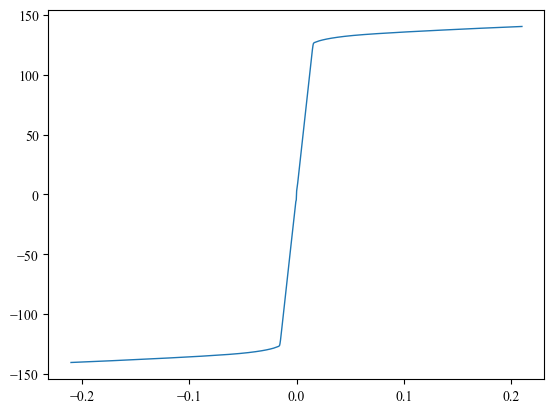

In [282]:
My = np.linspace(-150, 150, 401)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]

# Plotting the results
xsi = []
M_res = []
for i, M in enumerate(My):
	initial_guess = [0.000001, 0.000001, 0.0]
	result = fsolve(system_of_equations, initial_guess, args=(0, M, 0), full_output=1)
	if result[2] == 1:
		xsi.append(result[0][1])
		M_res.append(M)
plt.plot([x * 1000 for x in xsi], M_res,linestyle='-', lw=1)


In [284]:
from matplotlib import cm, colors

def plot_analysis_my(M_y):

	initial_guess = [0.000001, 0.000001, 0.0]
	result = fsolve(system_of_equations, initial_guess, args=(0, M_y, 0), full_output=1)
	res = result[0]
	Analysis.set_strain_and_curvature(res[0], res[1], res[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()

	# Normalize strains for color mapping
	strains_percent = [x * 100 for x in Analysis.strains]

	max_strain = max(abs(min(strains_percent)), abs(max(strains_percent)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (dia, strains, stresses) = plt.subplots(1,3, gridspec_kw={'width_ratios': [3, 3, 3]}, figsize=(17, 4), dpi=200)
	
	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(Analysis.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	strains.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_rebar_stress = max(abs(min(Analysis.stresses[Analysis.material_groups["Rebar_B500B"]])), 
	                       abs(max(Analysis.stresses[Analysis.material_groups["Rebar_B500B"]])))
	max_concrete_stress = max(abs(min(Analysis.stresses[Analysis.material_groups["Concrete_C30_37"]])),
	                          abs(max(Analysis.stresses[Analysis.material_groups["Concrete_C30_37"]])))
	norm_rebar = colors.TwoSlopeNorm(vmin=-max_rebar_stress, vcenter=0, vmax=max_rebar_stress)
	norm_concrete = colors.TwoSlopeNorm(vmin=-max_concrete_stress, vcenter=0, vmax=max_concrete_stress)
	cmap_rebar = plt.colormaps.get_cmap('coolwarm')
	cmap_concrete = plt.colormaps.get_cmap('PiYG')

	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		if elem.material.name == "Concrete_C30_37":
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap_concrete(norm_concrete(Analysis.stresses[i])),
									lw=0.0)

		elif elem.material.name == "Rebar_B500B":
			if abs(Analysis.stresses[i]) >= 435:
				poly = patches.Polygon(np.column_stack([x, y]),
										edgecolor='black',
										facecolor=cmap_rebar(norm_rebar(Analysis.stresses[i])),
										lw=0.4)
			else:
				poly = patches.Polygon(np.column_stack([x, y]),
										edgecolor='black',
										facecolor=cmap_rebar(norm_rebar(Analysis.stresses[i])),
										lw=0)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm_rebar = cm.ScalarMappable(cmap=cmap_rebar, norm=norm_rebar)
	sm_concrete = cm.ScalarMappable(cmap=cmap_concrete, norm=norm_concrete)
	sm_rebar.set_array([])
	sm_concrete.set_array([])
	plt.colorbar(sm_rebar, ax=stresses, label=r"rebar stress $\sigma$ [MPa]", shrink=0.7)
	plt.colorbar(sm_concrete, ax=stresses, label=r"concrete stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	stresses.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')

	dia.plot([x * 1000 for x in xsi], M_res, label=f'$M_y$ (max = {max(M_res):.3} kNm)')
	dia.set_xlabel(r'curvature - $\chi$ [$mrad$]')
	dia.set_ylabel(r'Bending Moment - $M_y$ [$kNm$]')
	dia.grid()
	dia.set_xlim(-0.07, 0.07)

	dia.scatter(res[1]*1000, M_y, color='red', zorder=5)

	plt.tight_layout()

In [285]:
import os
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

M_plot = np.linspace(0.1, 130, 50)

# Create a folder to store frames
os.makedirs("frames/concrete", exist_ok=True)

for i, M in enumerate(M_plot):
    plot_analysis_my(M)
    plt.savefig(f"frames/concrete/frame_{i:03d}.png")
    plt.close()

In [293]:
# Create GIF
from PIL import Image

images = [Image.open(f"frames/concrete/frame_{i:03d}.png") for i in range(len(M_plot))]
images[0].save("images/concrete/300x300_My.gif", save_all=True, append_images=images[1:], duration=300, loop=0)

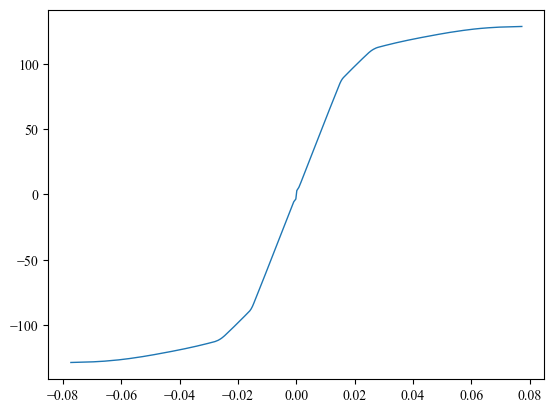

In [287]:
Mz = np.linspace(-150, 150, 601)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]

# Plotting the results
xsi = []
M_res = []
for i, M in enumerate(Mz):
	initial_guess = [0.000001, 0.000001, 0.0]
	result = fsolve(system_of_equations, initial_guess, args=(0, 0, M), full_output=1)
	if result[2] == 1:
		xsi.append(result[0][2])
		M_res.append(M)
plt.plot([x * 1000 for x in xsi], M_res,linestyle='-', lw=1)

In [288]:
from matplotlib import cm, colors

def plot_analysis_mz(M_z):

	initial_guess = [0.000001, 0.000001, 0.0]
	result = fsolve(system_of_equations, initial_guess, args=(0, 0, M_z), full_output=1)
	res = result[0]
	Analysis.set_strain_and_curvature(res[0], res[1], res[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()

	# Normalize strains for color mapping
	strains_percent = [x * 100 for x in Analysis.strains]

	max_strain = max(abs(min(strains_percent)), abs(max(strains_percent)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (dia, strains, stresses) = plt.subplots(1,3, gridspec_kw={'width_ratios': [3, 3, 3]}, figsize=(17, 4), dpi=200)
	
	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(Analysis.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	strains.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_rebar_stress = max(abs(min(Analysis.stresses[Analysis.material_groups["Rebar_B500B"]])), 
	                       abs(max(Analysis.stresses[Analysis.material_groups["Rebar_B500B"]])))
	max_concrete_stress = max(abs(min(Analysis.stresses[Analysis.material_groups["Concrete_C30_37"]])),
	                          abs(max(Analysis.stresses[Analysis.material_groups["Concrete_C30_37"]])))
	norm_rebar = colors.TwoSlopeNorm(vmin=-max_rebar_stress, vcenter=0, vmax=max_rebar_stress)
	norm_concrete = colors.TwoSlopeNorm(vmin=-max_concrete_stress, vcenter=0, vmax=max_concrete_stress)
	cmap_rebar = plt.colormaps.get_cmap('coolwarm')
	cmap_concrete = plt.colormaps.get_cmap('PiYG')

	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		if elem.material.name == "Concrete_C30_37":
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap_concrete(norm_concrete(Analysis.stresses[i])),
									lw=0.0)

		elif elem.material.name == "Rebar_B500B":
			if abs(Analysis.stresses[i]) >= 435:
				poly = patches.Polygon(np.column_stack([x, y]),
										edgecolor='black',
										facecolor=cmap_rebar(norm_rebar(Analysis.stresses[i])),
										lw=0.4)
			else:
				poly = patches.Polygon(np.column_stack([x, y]),
										edgecolor='black',
										facecolor=cmap_rebar(norm_rebar(Analysis.stresses[i])),
										lw=0)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm_rebar = cm.ScalarMappable(cmap=cmap_rebar, norm=norm_rebar)
	sm_concrete = cm.ScalarMappable(cmap=cmap_concrete, norm=norm_concrete)
	sm_rebar.set_array([])
	sm_concrete.set_array([])
	plt.colorbar(sm_rebar, ax=stresses, label=r"rebar stress $\sigma$ [MPa]", shrink=0.7)
	plt.colorbar(sm_concrete, ax=stresses, label=r"concrete stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	stresses.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')

	dia.plot([x * 1000 for x in xsi], M_res, label=f'$M_y$ (max = {max(M_res):.3} kNm)')
	dia.set_xlabel(r'curvature - $\chi$ [$mrad$]')
	dia.set_ylabel(r'Bending Moment - $M_y$ [$kNm$]')
	dia.grid()
	dia.set_xlim(-0.07, 0.07)

	dia.scatter(res[2]*1000, M_z, color='red', zorder=5)

	plt.tight_layout()

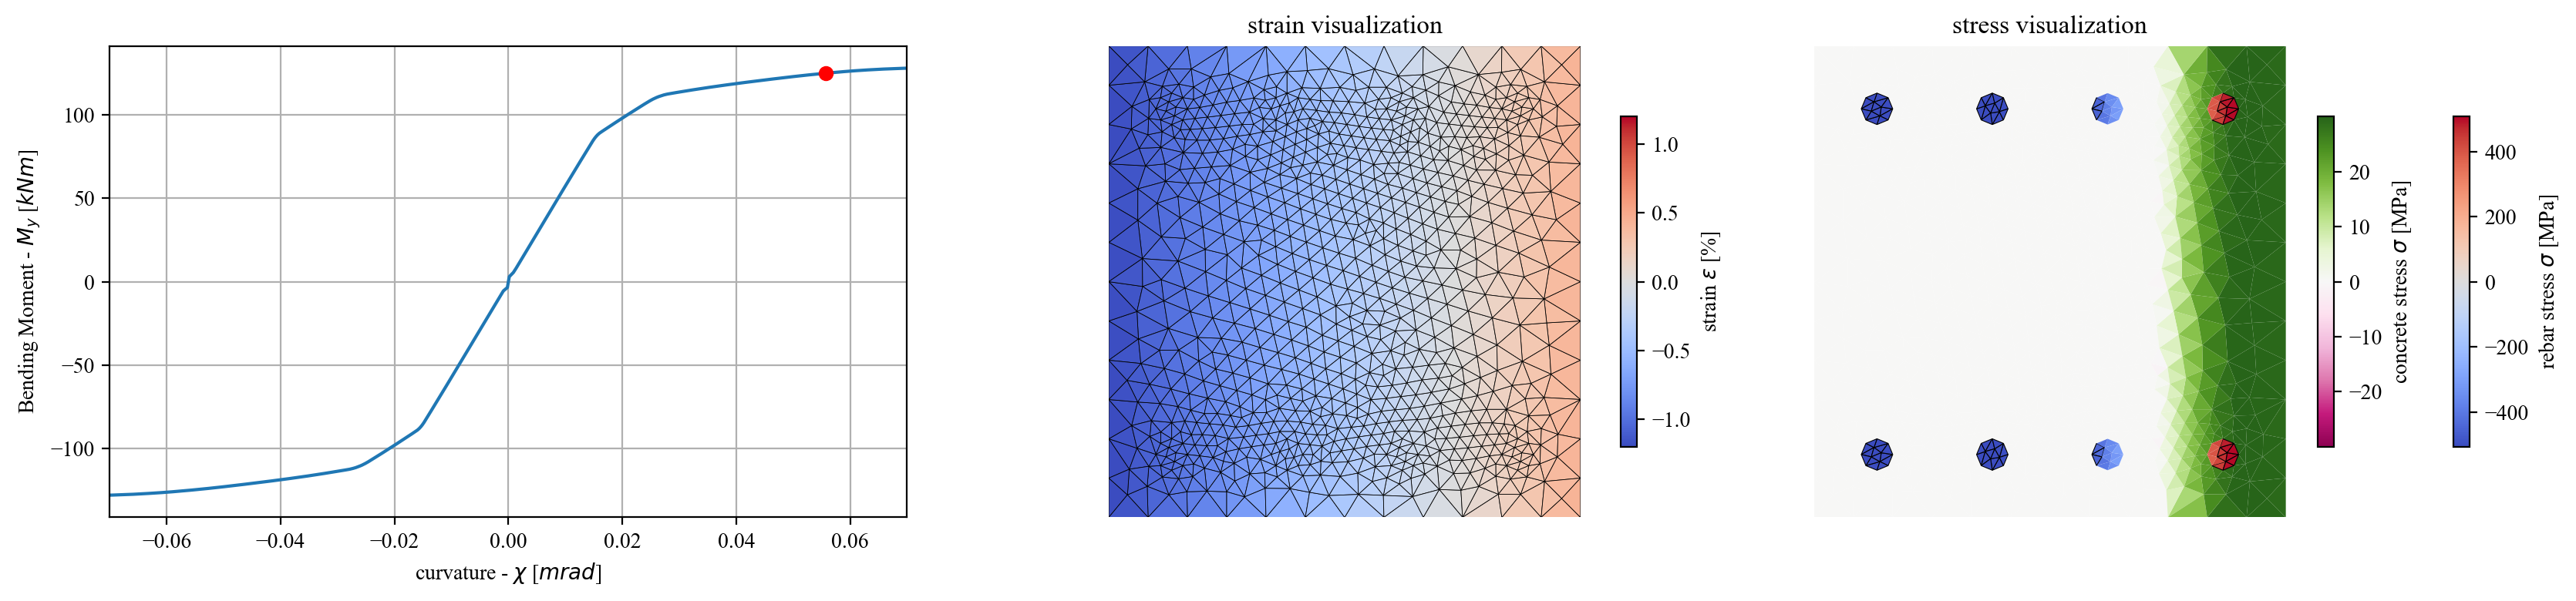

In [289]:
plot_analysis_mz(125)

In [290]:
import os
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

M_plot = np.linspace(0.1, 125, 50)

# Create a folder to store frames
os.makedirs("frames/concrete", exist_ok=True)

for i, M in enumerate(M_plot):
    plot_analysis_mz(M)
    plt.savefig(f"frames/concrete/frame_mz_{i:03d}.png")
    plt.close()

In [292]:
# Create GIF
from PIL import Image

images = [Image.open(f"frames/concrete/frame_mz_{i:03d}.png") for i in range(len(M_plot))]
images[0].save("images/concrete/300x300_Mz.gif", save_all=True, append_images=images[1:], duration=300, loop=0)